This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [7]:
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mticker

import os
from collections import Counter
import seaborn as sns
import json
from sklearn.metrics import adjusted_rand_score

from src_python.mutation_filter import MutationFilter
from src_python.cell_tree import CellTree
from src_python.mutation_tree import MutationTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, create_mutation_matrix, \
    create_genotype_matrix, mut_count_distance
from dendropy import Tree, TreeList, TaxonNamespace

In [8]:
path = "../data/simulated_data"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = ["", 5, 10, 20]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
likelihood_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}
adjusted_rand_index = {"SCITE-RNA": {}}

n_round = 1

config = load_config_and_set_random_seed()

In [9]:
mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                                    genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                                    dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                                    dropout_direction_prob=config["dropout_direction"],
                                    overdispersion_h=config["overdispersion_h"])

if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):

        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                flipped_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)

                ct_sciterna.use_parent_vec(sciterna_parent_vec)
                ct_sciterna.flipped = flipped_sciterna

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(differences), " mean abs difference of vafs predicted")

In [10]:

#
# mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
#                                     genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
#                                     dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
#                                     dropout_direction_prob=config["dropout_direction"],
#                                     overdispersion_h=config["overdispersion_h"])
#
# if not use_summary_statistics:
#     for n_c, n_m in zip(n_cells, n_mut):
#         genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
#         for clone in clones:
#             differences = []
#             path_len_distances = []
#             likelihoods = []
#             mut_count_distances = []
#
#             for t in range(n_tests):
#                 base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
#                 genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
#                 genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
#                 ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
#                 alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
#
#                 genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
#                 # print(np.count_nonzero(genotype_pred == "H"), "H pred")
#                 gt = np.loadtxt(genotype_path, dtype=str)
#                 # print(np.count_nonzero(gt == "H"), "H gt")
#                 alt = np.loadtxt(alt_path)
#                 ref = np.loadtxt(ref_path)
#                 true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
#                 sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)
#
#                 mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
#                 vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
#                 genotype_predicted = vectorized_map(genotype_pred)
#                 genotype_gt = vectorized_map(gt)
#                 unique_genotypes = np.unique(genotype_gt, axis=0)
#
#                 difference = np.mean(np.abs(genotype_predicted - genotype_gt))
#                 differences.append(difference)
#
#                 flipped_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)
#                 selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
#                 gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
#                 # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
#                 mut_location_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_mutation_location", f"sciterna_mutation_location_{n_round}r{t}.txt"), dtype=int)
#                 mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)
#                 # attachment_probs = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_attachment_probs", f"sciterna_attachment_probs_{n_round}r{t}.txt"), dtype=float)
#
#                 ct_gt = CellTree(n_c)
#                 # ct_gt.fit_llh(llh_1, llh_2)
#                 ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)
#                 # ct_sciterna.fit_llh(llh_1, llh_2)
#
#                 ct_gt.use_parent_vec(true_parent_vec)
#                 ct_gt.mut_loc = mut_location[selected]
#
#                 ct_sciterna.use_parent_vec(sciterna_parent_vec)
#                 ct_sciterna.flipped = flipped_sciterna
#
#                 # n_true_clones = len(np.unique(genotype_gt, axis=0, return_counts=True)[0]) - 1
#                 # ct_sciterna.update_mut_loc_experimental(n_true_clones)
#
#                 # mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
#                 path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
#
#                 # ct_sciterna.mut_loc = mut_location_sciterna
#                 # mut_matrix = create_mutation_matrix(sciterna_parent_vec, ct_sciterna.mut_loc, ct_sciterna)
#                 # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sciterna.flipped)
#                 # genotype_matrix = vectorized_map(genotype_matrix)
#
#                 # expected_genotype = expected_genotype_matrix(ct_sciterna, sciterna_parent_vec, attachment_probs, gt1, gt2, selected, mut_location_sciterna)
#                 #
#                 # os.makedirs(os.path.join(base_path, "sciterna", "sciterna_genotype_marginal"), exist_ok=True)
#                 # np.savetxt(os.path.join(base_path, "sciterna", "sciterna_genotype_marginal", f"sciterna_genotype_marginal_{n_round}r{t}.txt"), expected_genotype)
#                 # expected_genotype = np.round(expected_genotype * 2) / 2
#                 # difference = np.mean(np.abs(expected_genotype - genotype_gt))
#                 # difference = np.mean(np.abs(genotype_matrix - genotype_gt))
#                 # differences.append(difference)
#
#                 # m_dist = mut_count_distance(genotype_gt, genotype_matrix)
#                 # mut_count_distances.append(m_dist)
#
#                 # likelihoods.append((ct_sciterna.joint - ct_gt.joint) / (ct_sciterna.n_cells * ct_sciterna.n_mut))
#
#                 # graph_gt = ct_gt.to_graphviz()
#                 #
#                 # unique_mut_locs = set(ct_gt.mut_loc)
#                 # colors = list(["red", "blue", "green", "orange", "lightblue"])  # Using CSS color names
#                 # mut_loc_color_map = {mut_loc: colors[i % len(colors)] for i, mut_loc in enumerate(unique_mut_locs)}
#                 #
#                 # new_body_gt = []
#                 # for line in graph_gt.body:
#                 #     if '->' in line and 'label="' in line:
#                 #         label_match = re.search(r'label="([^"]*)"', line)
#                 #         if label_match:
#                 #             label_val = label_match.group(1)
#                 #             if label_val:
#                 #                 first_mut = int(label_val.split(',')[0])
#                 #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
#                 #                 line = line.replace(']', f', fontcolor="{fontcolor}"]')
#                 #     new_body_gt.append(line)
#                 #
#                 # graph_gt.body = new_body_gt
#                 #
#                 # graph_sciterna = ct_sciterna.to_graphviz()
#                 #
#                 # new_body_sciterna = []
#                 # for line in graph_sciterna.body:
#                 #     if '->' in line and 'label=' in line:
#                 #         # Extract the label value, accounting for both quoted and unquoted labels
#                 #         label_match = re.search(r'label=(["\']?)([^\'"\s]*)\1', line)
#                 #         if label_match:
#                 #             label_val = label_match.group(2)
#                 #             if label_val:
#                 #                 # Split the label into parts if it contains commas
#                 #                 muts = label_val.split(',')
#                 #                 # Use the first mutation ID
#                 #                 first_mut = int(muts[0])
#                 #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
#                 #                 # Replace or add the fontcolor attribute
#                 #                 if ']' in line:
#                 #                     line = line.replace(']', f', fontcolor="{fontcolor}"]')
#                 #                 else:
#                 #                     line = line.rstrip() + f' fontcolor="{fontcolor}"]'
#                 #     new_body_sciterna.append(line)
#                 #
#                 # graph_sciterna.body = new_body_sciterna
#                 #
#                 # graph_gt.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_gt_{t}.png"), format='png', cleanup=True)
#                 # graph_sciterna.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_sciterna_{n_round}r{t}.png"), format='png', cleanup=True)
#                 # sns.heatmap(genotype_gt)
#                 # plt.title(f"Genotype Matrix GT {t}")
#                 # plt.show()
#                 # sns.heatmap(genotype_predicted)
#                 # plt.title(f"Genotype Matrix Predicted {t}")
#                 # plt.show()
#                 #
#                 # sns.heatmap(np.abs(genotype_gt - genotype_predicted))
#                 # plt.title(f"Genotype Matrix Difference {t}")
#                 # plt.show()
#                 #
#                 # sns.heatmap(alt/(alt + ref))
#                 # plt.title(f"VAF Matrix {t}")
#                 # plt.show()
#
#             genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
#             path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
#             likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
#             mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
#             print(np.mean(differences), " mean abs difference of vafs predicted")
#             print(np.mean(path_len_distances), " mean path length distance")
#             # print(np.mean(likelihoods), " mean likelihood difference")
#             print(np.mean(mut_count_distances), " mean mutation count distance")

In [11]:
genotype_differences["SCITE-RNA"] = {}
path_len_differences["SCITE-RNA"] = {}
likelihood_differences["SCITE-RNA"] = {}
mut_count_differences["SCITE-RNA"] = {}
adjusted_rand_index["SCITE-RNA"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0669256  mean abs difference of vafs predicted
3.4515999999999996  mean path length distance
4.505632304609218  mean mutation count distance
1.0  mean adjusted rand index
0.0633464  mean abs difference of vafs predicted
4.284881632653061  mean path length distance
5.211929138276554  mean mutation count distance
0.3464853570416108  mean adjusted rand index
0.07903679999999999  mean abs difference of vafs predicted
3.808408163265306  mean path length distance
6.343857875751501  mean mutation count distance
0.4768041565600003  mean adjusted rand index
0.09208719999999998  mean abs difference of vafs predicted
3.4584816326530614  mean path length distance
6.156144048096194  mean mutation count distance
0.4631792027564529  mean adjusted rand index


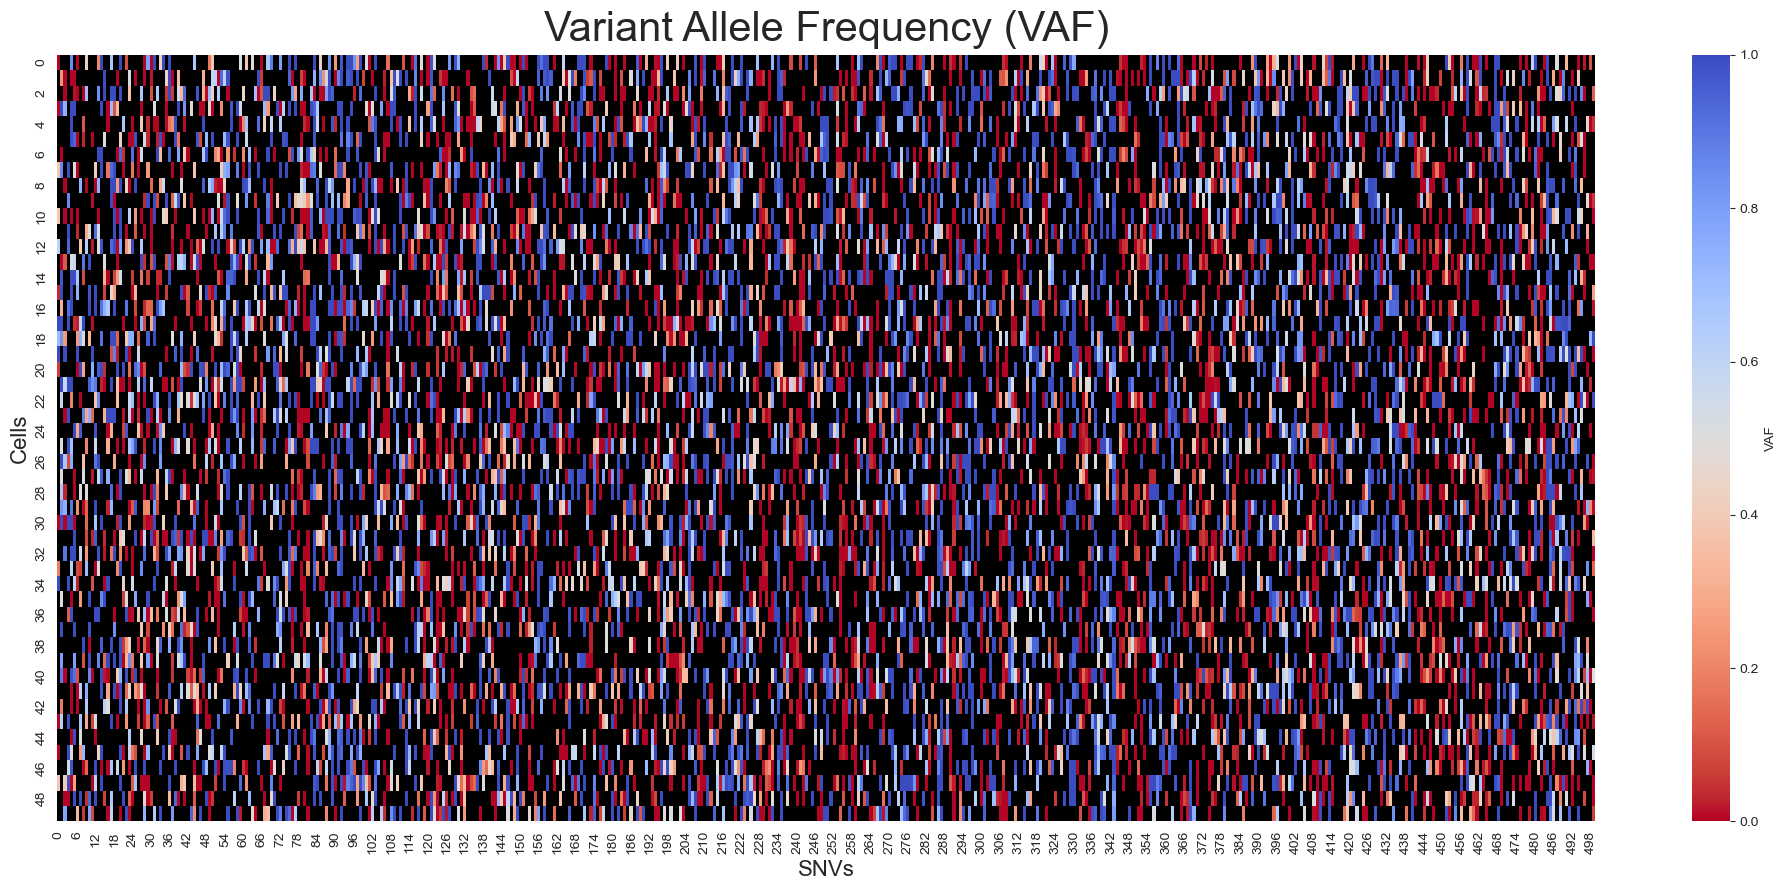

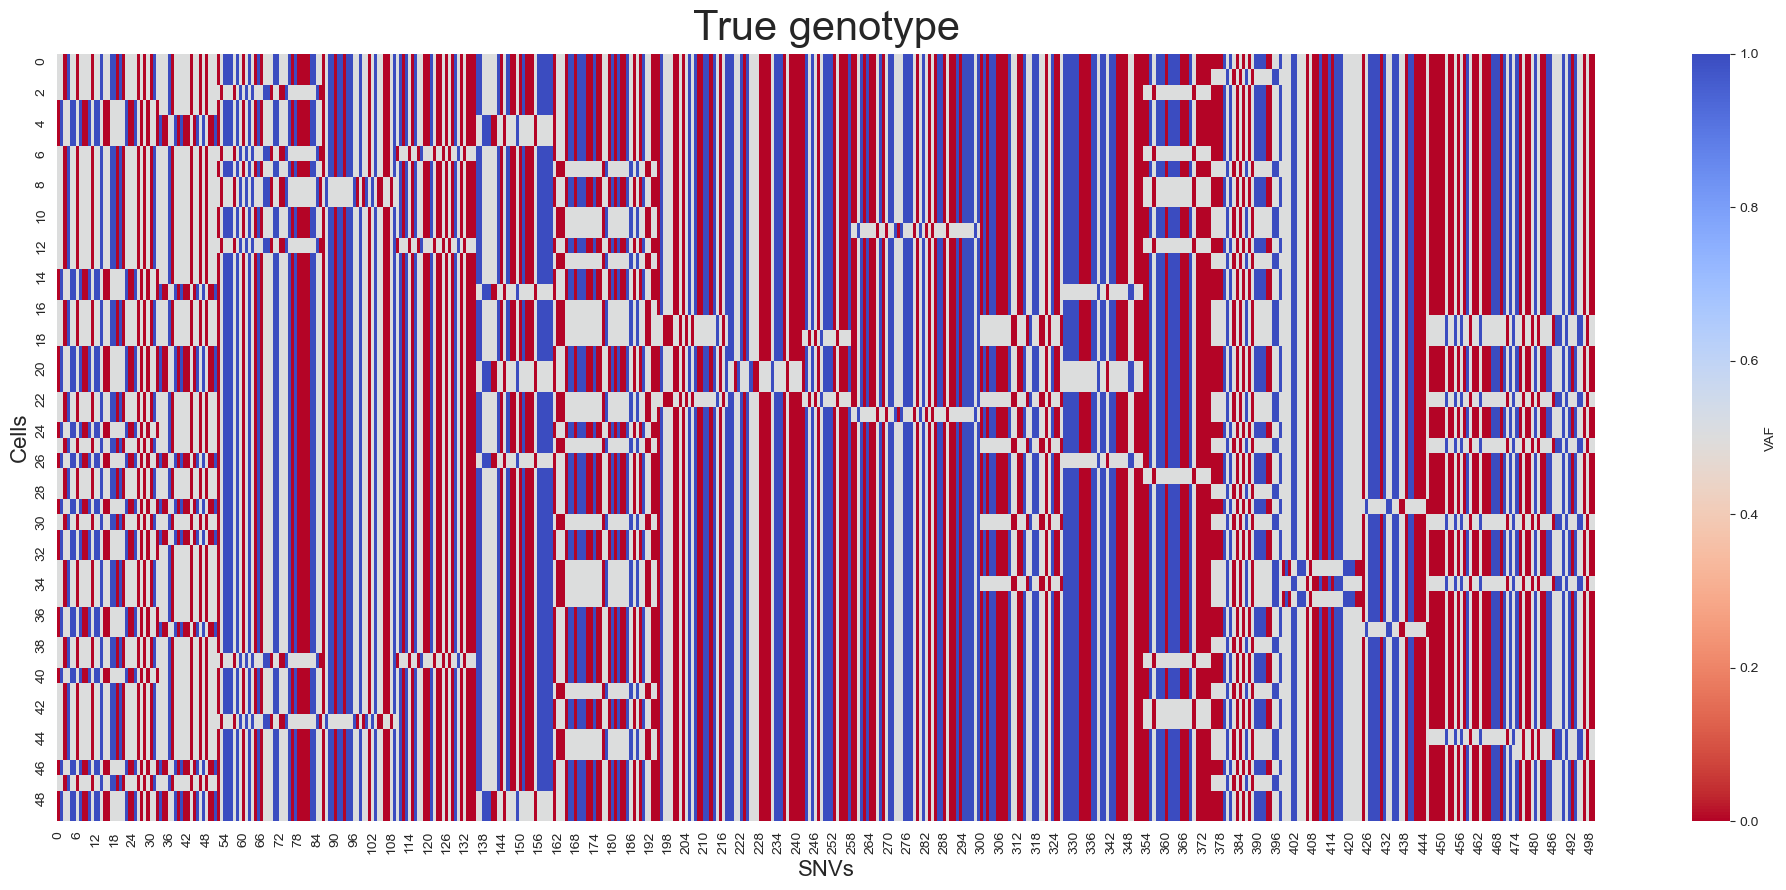

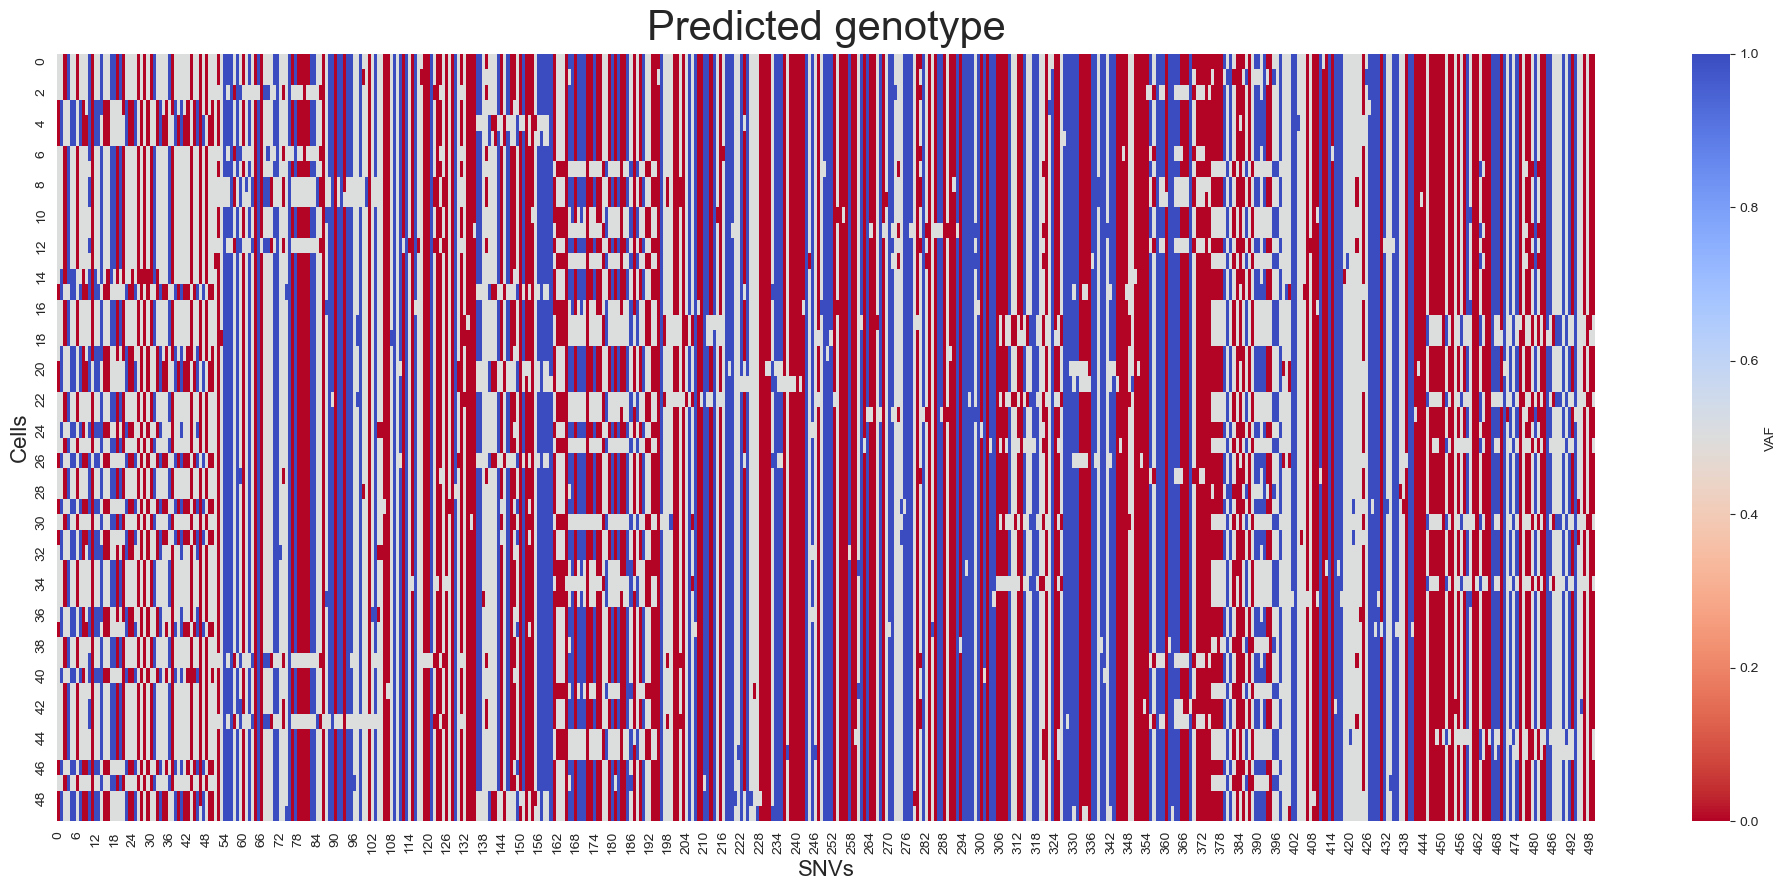

In [12]:
for t in range(n_tests-1, n_tests):
    alt = np.loadtxt(os.path.join(base_path, "alt", f"alt_{t}.txt"), dtype=int)
    ref = np.loadtxt(os.path.join(base_path, "ref", f"ref_{t}.txt"), dtype=int)
    mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)
    selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
    genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str)
    sciterna_genotype = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt"), dtype=str)

    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_gt = vectorized_map(genotype_gt)
    genotype_predicted = vectorized_map(sciterna_genotype)
    # genotype_predicted = genotype_matrix
    # genotype_predicted = expected_genotype

    unique_sorted = np.sort(np.unique(mut_location))
    leaf_order = np.argsort([np.where(unique_sorted == x)[0][0] for x in mut_location])

    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = alt / (ref + alt)

    vaf = vaf[:,leaf_order]
    genotype_gt = genotype_gt[:,leaf_order]
    genotype_predicted = genotype_predicted[:,leaf_order]

    # Define colormap: black for NaN, color gradient for valid values
    base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
    cmap_with_nan = base_cmap
    cmap_with_nan.set_bad(color='black')

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        vaf,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Variant Allele Frequency (VAF)", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_gt,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"True genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_predicted,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Predicted genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

In [13]:
genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
likelihood_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}
adjusted_rand_index["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                # genotype_gt = vectorized_map(gt)
                genotype_gt = np.round(vaf_predicted * 2) / 2

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))

                genotype_predicted = np.round(vaf_observed * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print("The shapes of the predicted and ground truth genotypes do not match.")
                    continue
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SClineager"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

The shapes of the predicted and ground truth genotypes do not match.
The shapes of the predicted and ground truth genotypes do not match.
The shapes of the predicted and ground truth genotypes do not match.
The shapes of the predicted and ground truth genotypes do not match.
0.05044166666666667  mean abs difference of vafs predicted
4.580901360544218  mean path length distance
3.1927707915831665  mean mutation count distance
1.0  mean adjusted rand index
The shapes of the predicted and ground truth genotypes do not match.
0.08608424242424242  mean abs difference of vafs predicted
4.370224695938982  mean path length distance
5.596694317928787  mean mutation count distance
0.3418213154611852  mean adjusted rand index
The shapes of the predicted and ground truth genotypes do not match.
The shapes of the predicted and ground truth genotypes do not match.
0.09748795918367346  mean abs difference of vafs predicted
4.485614327363598  mean path length distance
5.135916077052063  mean mutation 

In [14]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
likelihood_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}
adjusted_rand_index["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")

                gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if gt.ndim == 1:
                    gt = gt[:, np.newaxis]

                _, clones_gt = np.unique(gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)


                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0669256  mean abs difference of vafs predicted
4.596710204081632  mean path length distance
4.505632304609218  mean mutation count distance
1.0  mean adjusted rand index
0.0740492  mean abs difference of vafs predicted
4.468057142857142  mean path length distance
5.616639358717435  mean mutation count distance
0.22905652107408417  mean adjusted rand index
0.10982820000000001  mean abs difference of vafs predicted
4.5897469387755105  mean path length distance
6.726406332665332  mean mutation count distance
0.10631680012029529  mean adjusted rand index
0.11377319999999998  mean abs difference of vafs predicted
4.540767346938776  mean path length distance
6.307790541082165  mean mutation count distance
0.05544665509239558  mean adjusted rand index


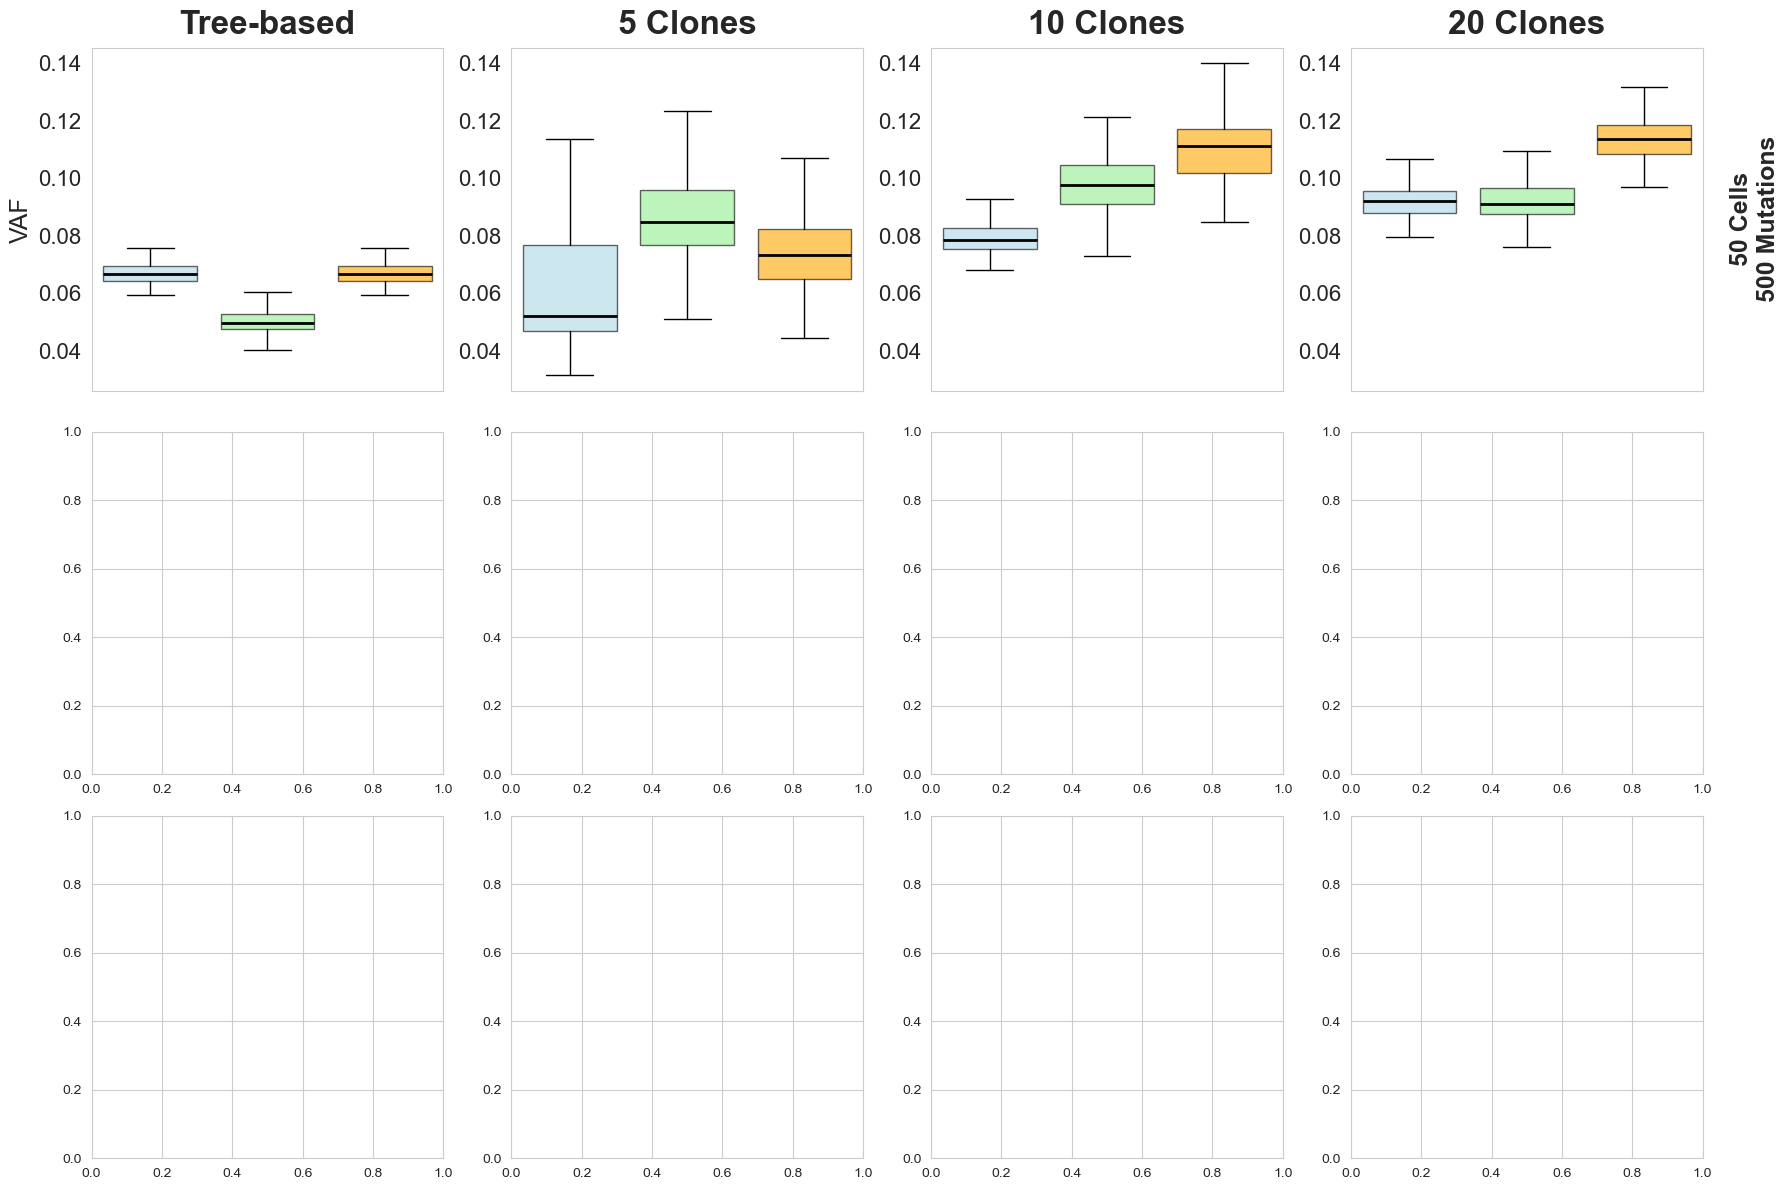

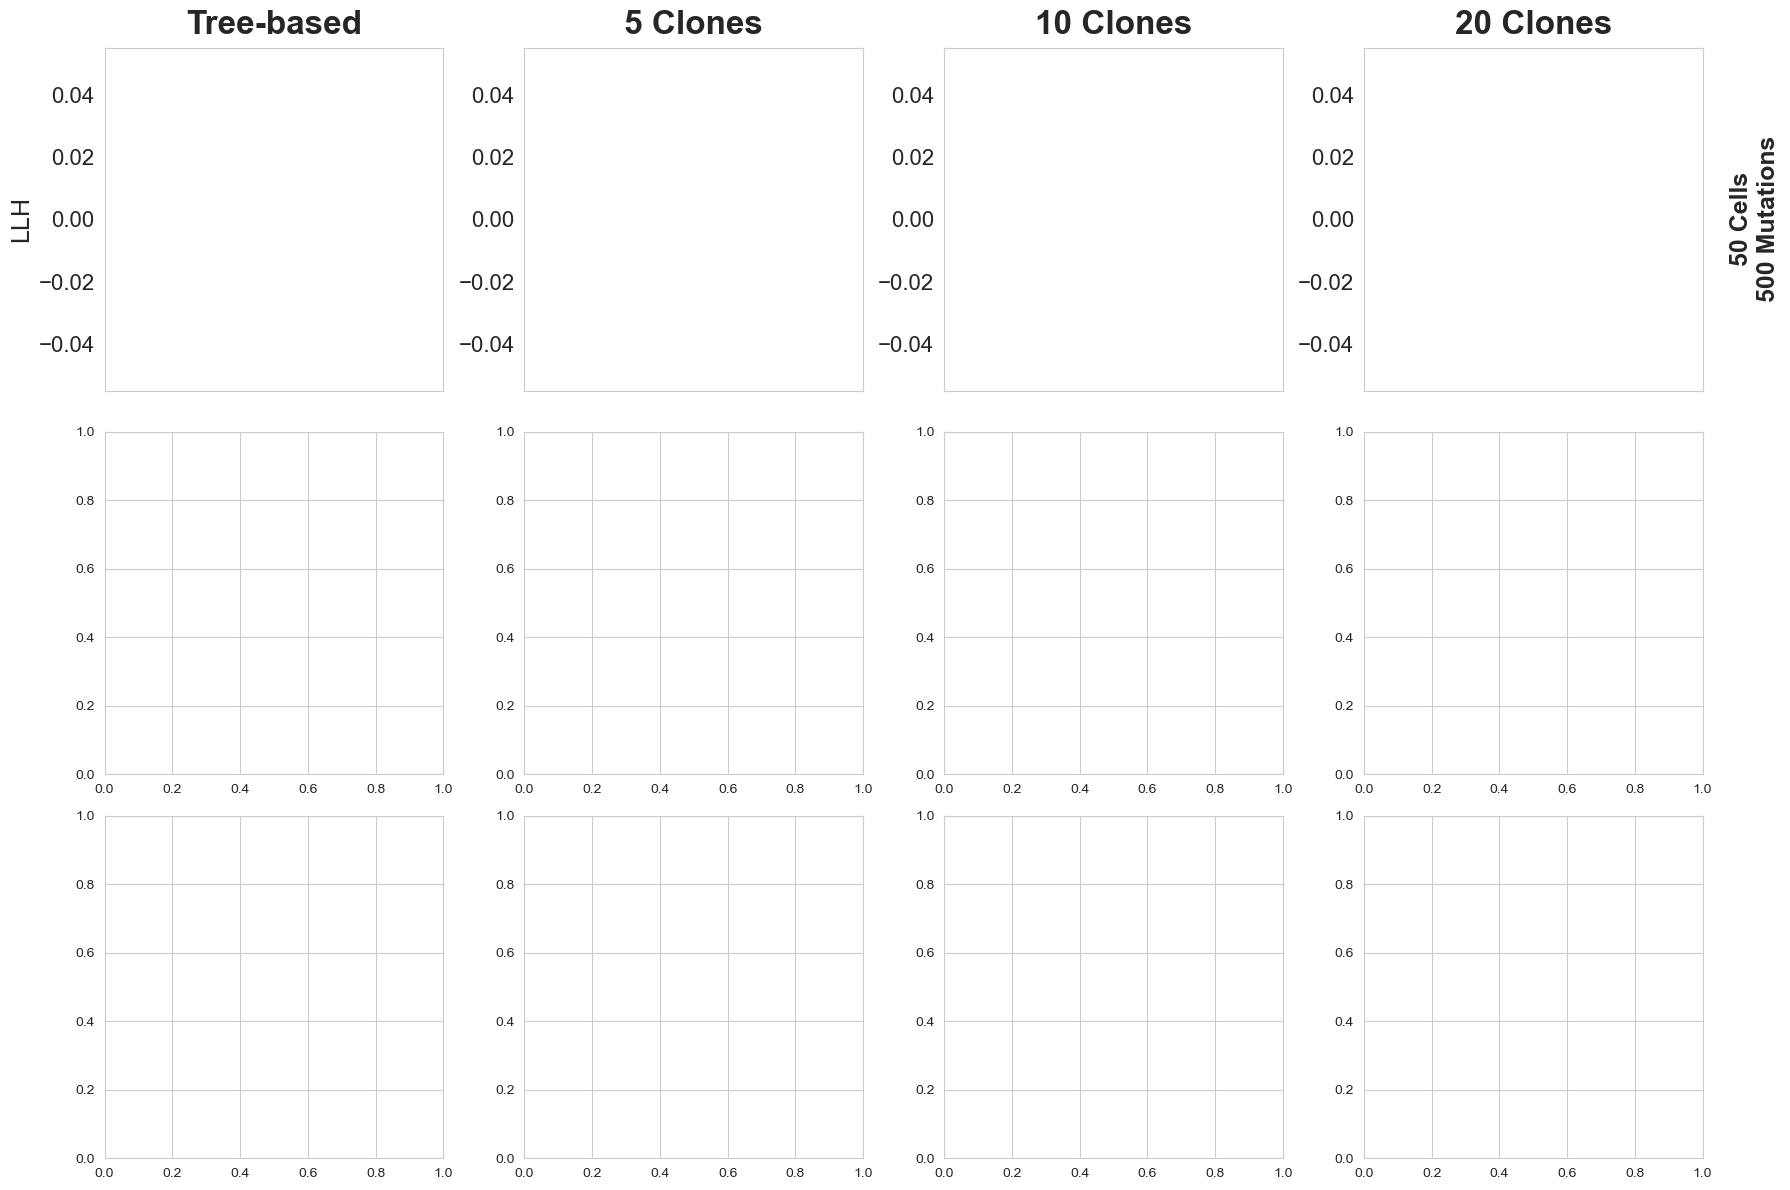

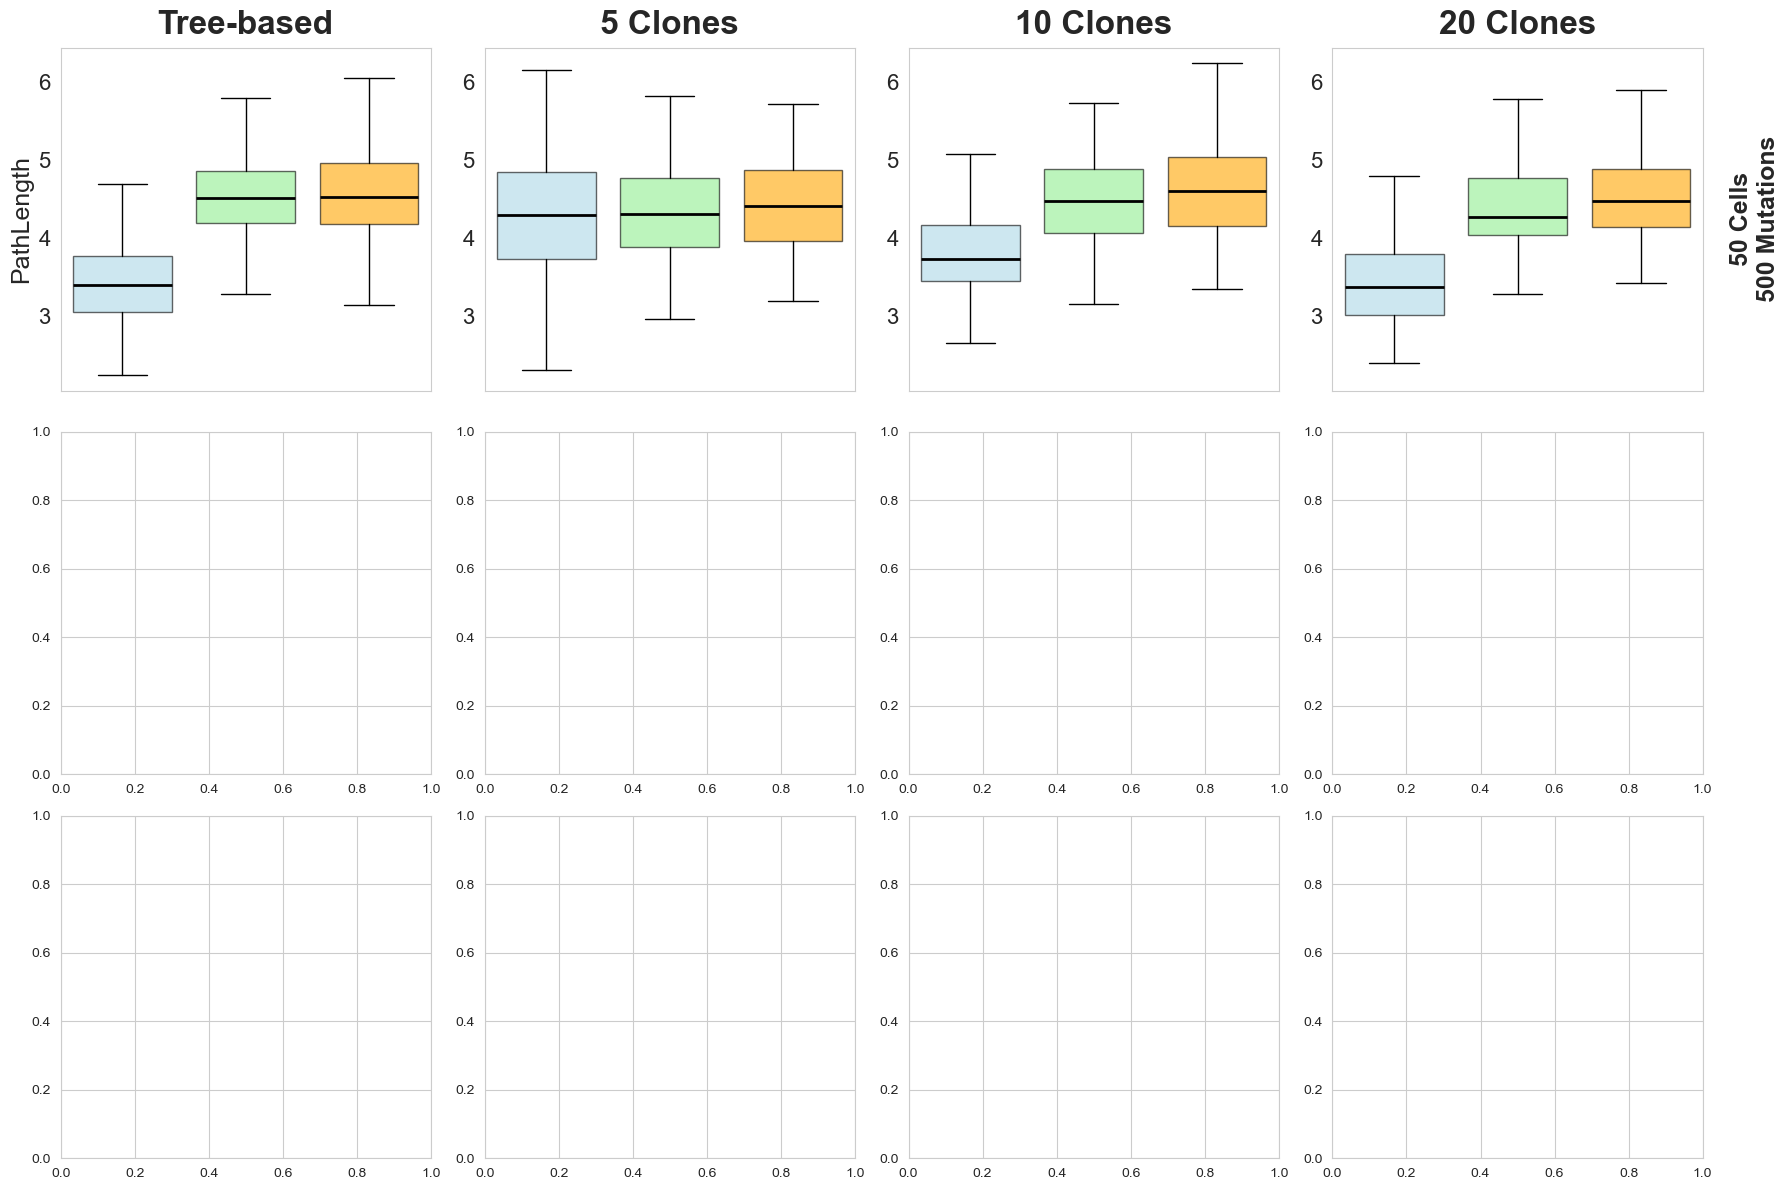

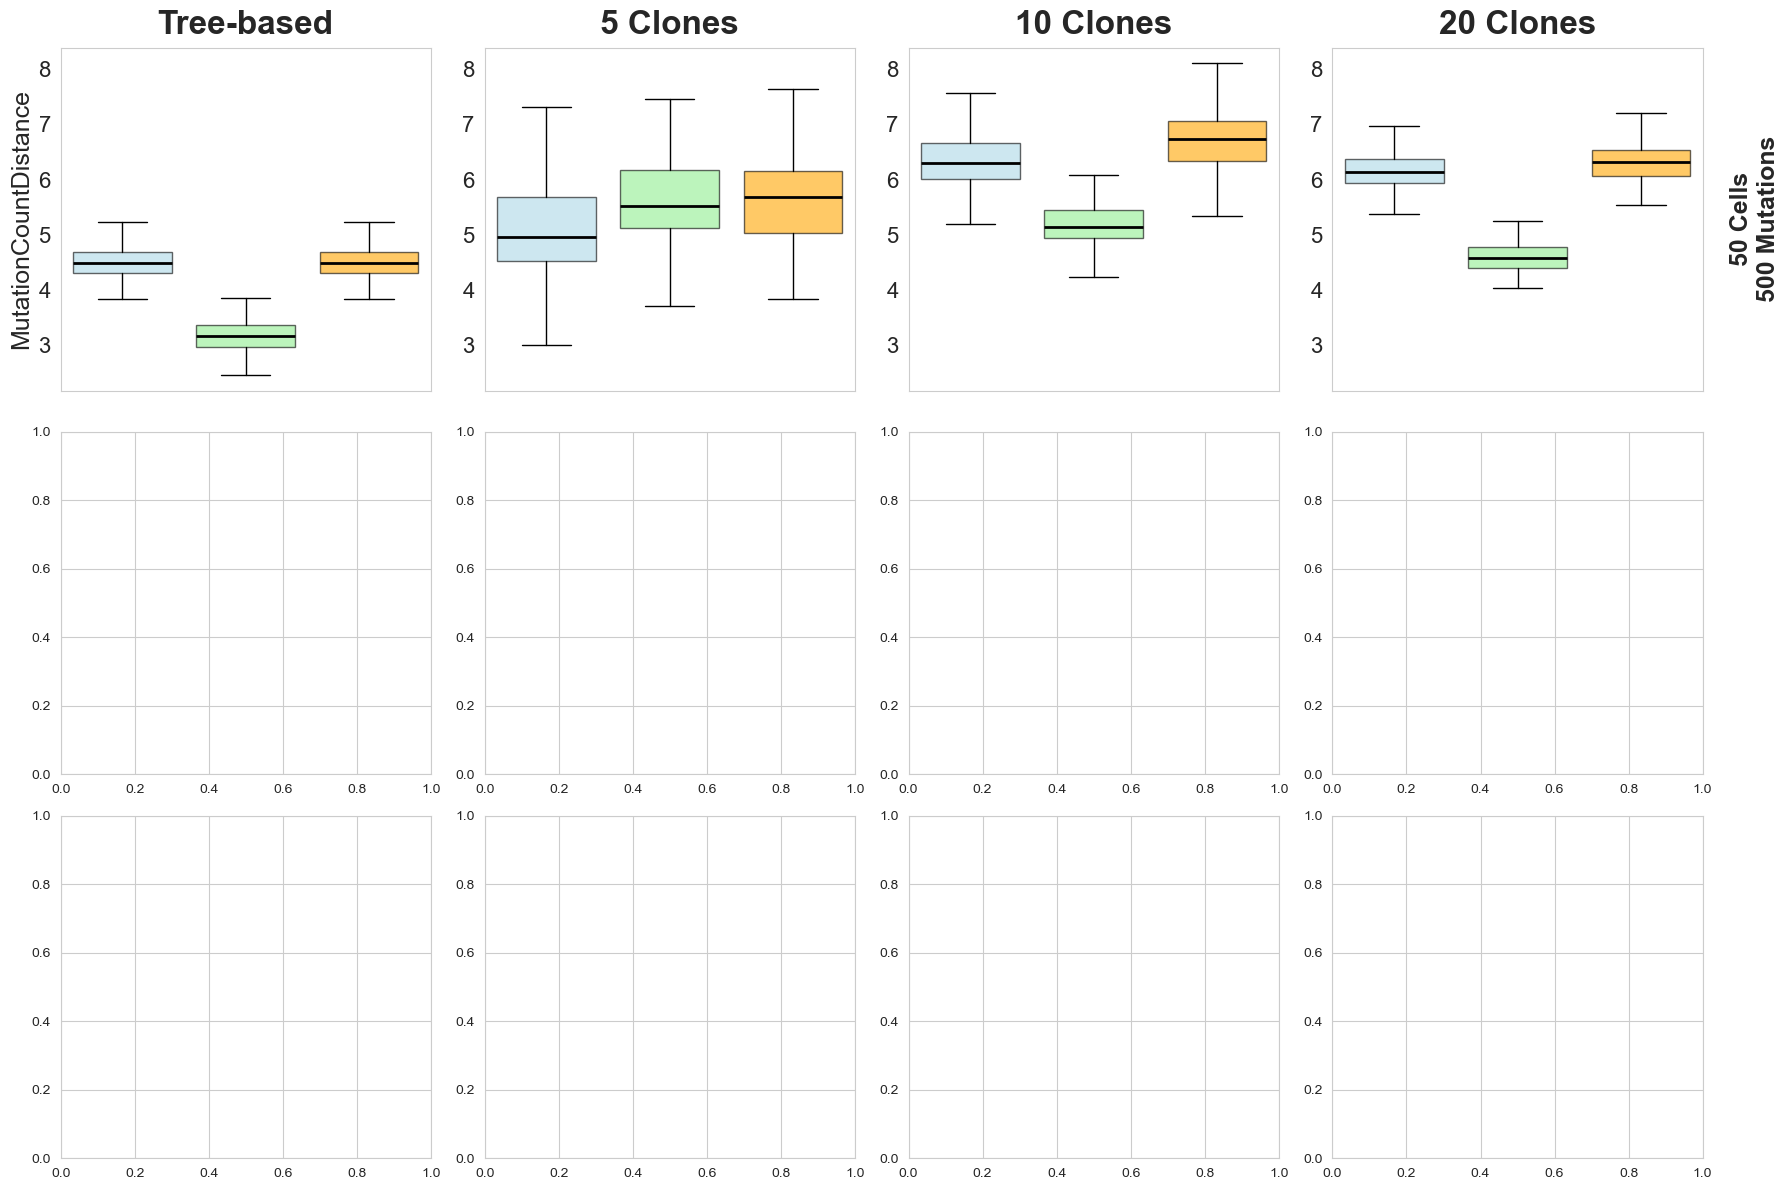

In [15]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

def plot_results(results_data, title=""):
    models = ["SCITE-RNA", "SClineager", "DENDRO"]

    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=False)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    row_y_limits = []

    for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            all_samples = [results_data[model][f"{n_c}_{n_m}"][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            # Collect whisker data for row-level y-limit setting
            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 2:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(f'{title}', fontsize=label_size)
            if col_idx == 3:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

        # After processing all columns in a row, set common y-limits
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin -= 0.05 * yrange
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(len(clones)):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f"../data/results/figures/clones_{title}.png")
    plt.show()

plot_results(genotype_differences, "VAF")
plot_results(likelihood_differences, "LLH")
plot_results(path_len_differences, "PathLength")
plot_results(mut_count_differences, "MutationCountDistance")

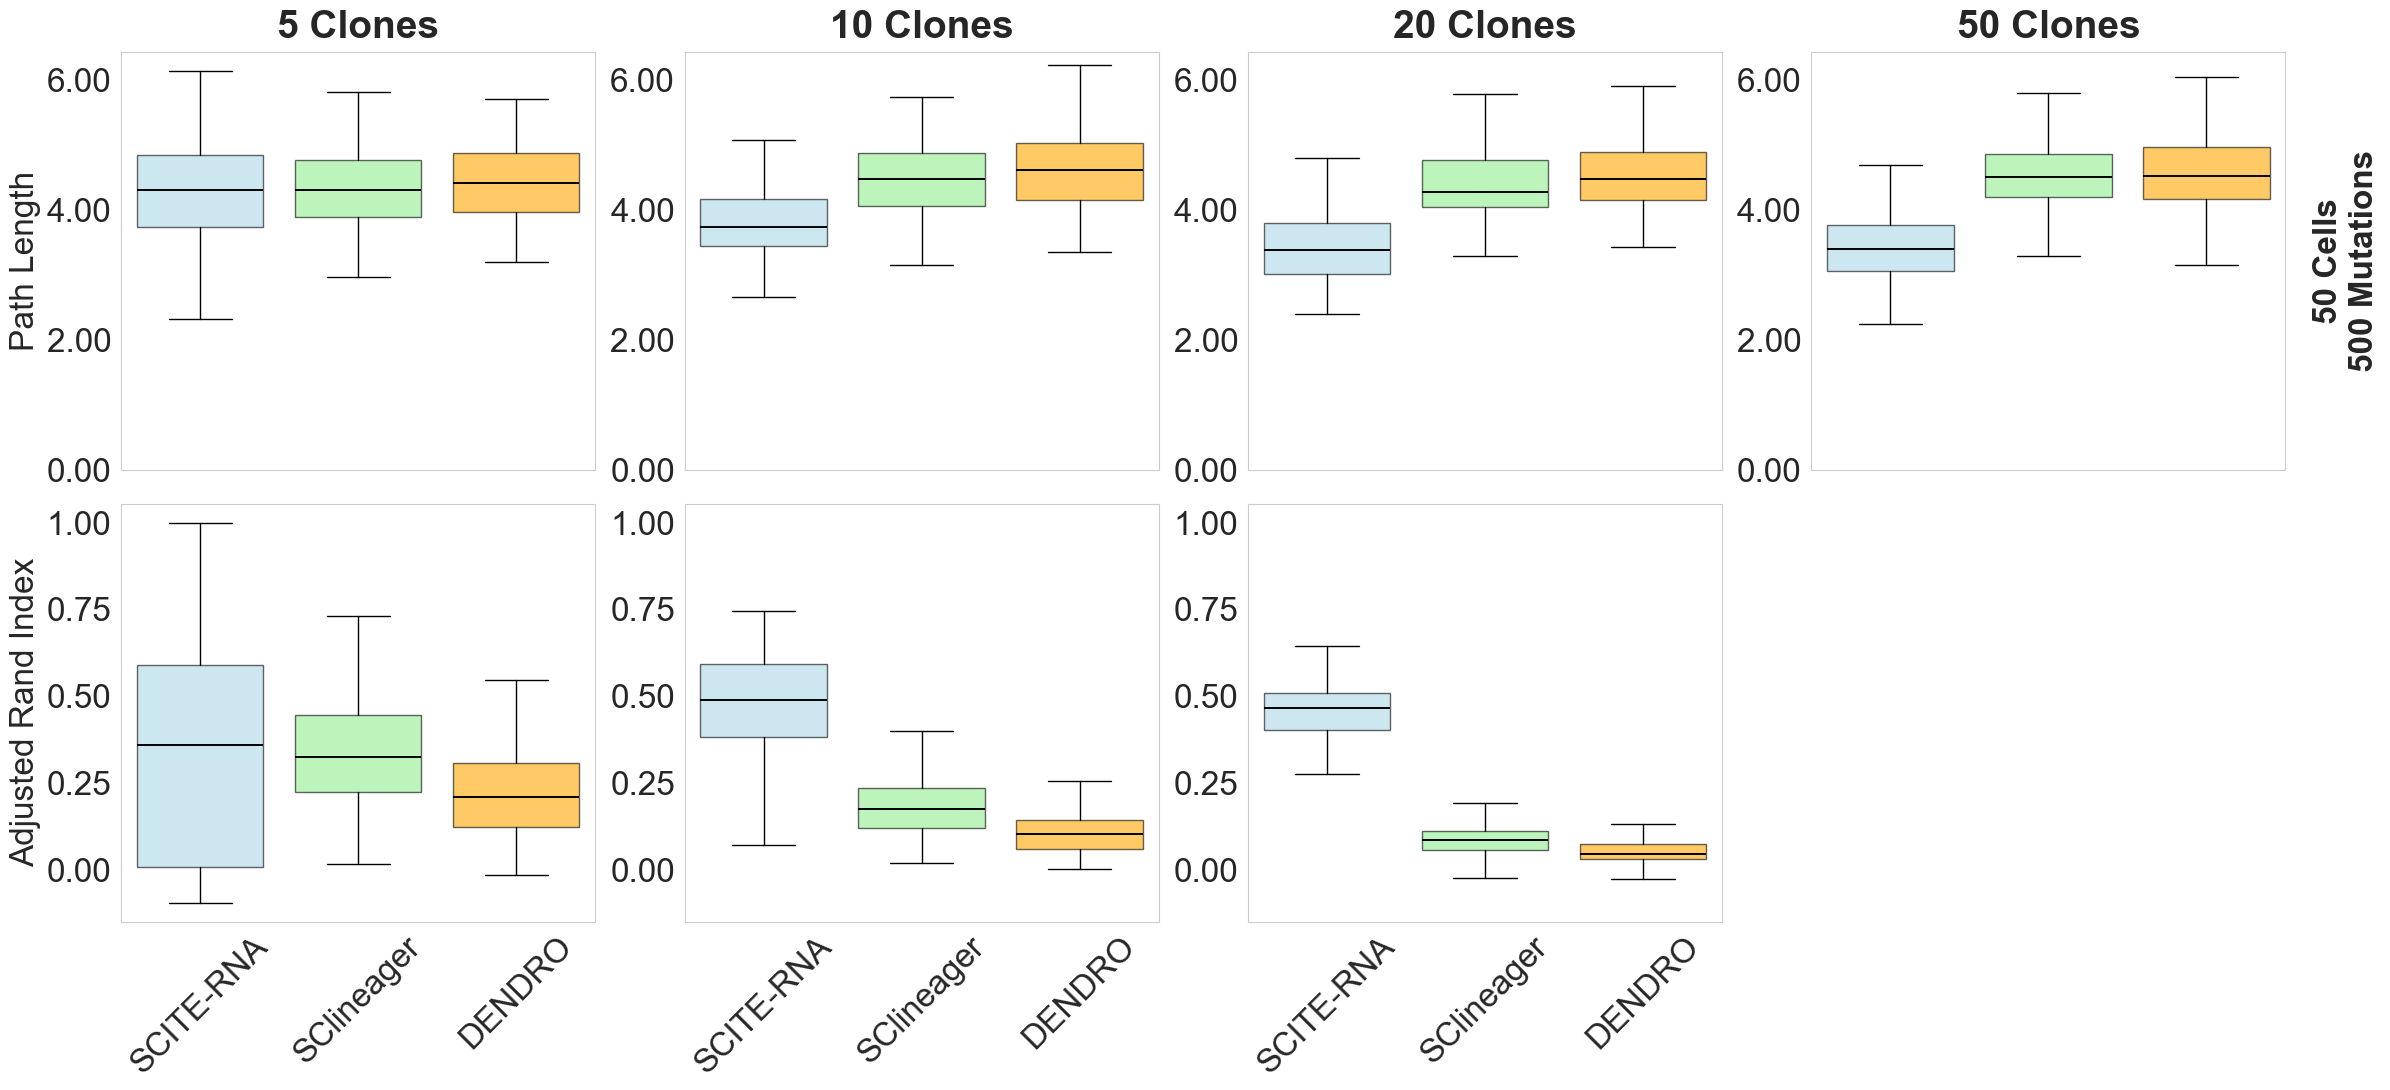

In [25]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO"]):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties
    import matplotlib.ticker as mticker

    # Configuration
    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 28
    label_size = 24
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Length", "Adjusted Rand Index"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            ax = axes[row_idx, col_idx]

            # Skip plotting ARI for 50 clones column
            if row_idx == 1 and clone == "":
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                if col_idx == 0:
                    ax.set_ylabel(plot_title, fontsize=label_size)
                continue

            all_samples = [data[model][sample_key][clone] for model in models]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row (only if there is data)
        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            ymin, ymax = combined.min(), combined.max()
            yrange = ymax - ymin
            ymin = min(ymin - 0.05 * yrange, 0)
            ymax += 0.05 * yrange

            if np.isfinite(ymin):
                for col_idx in range(cols):
                    if not (row_idx == 1 and clones[col_idx] == ""):
                        axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/combined_PathLength_RandIndex.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, adjusted_rand_index, [5, 10, 20, ""])

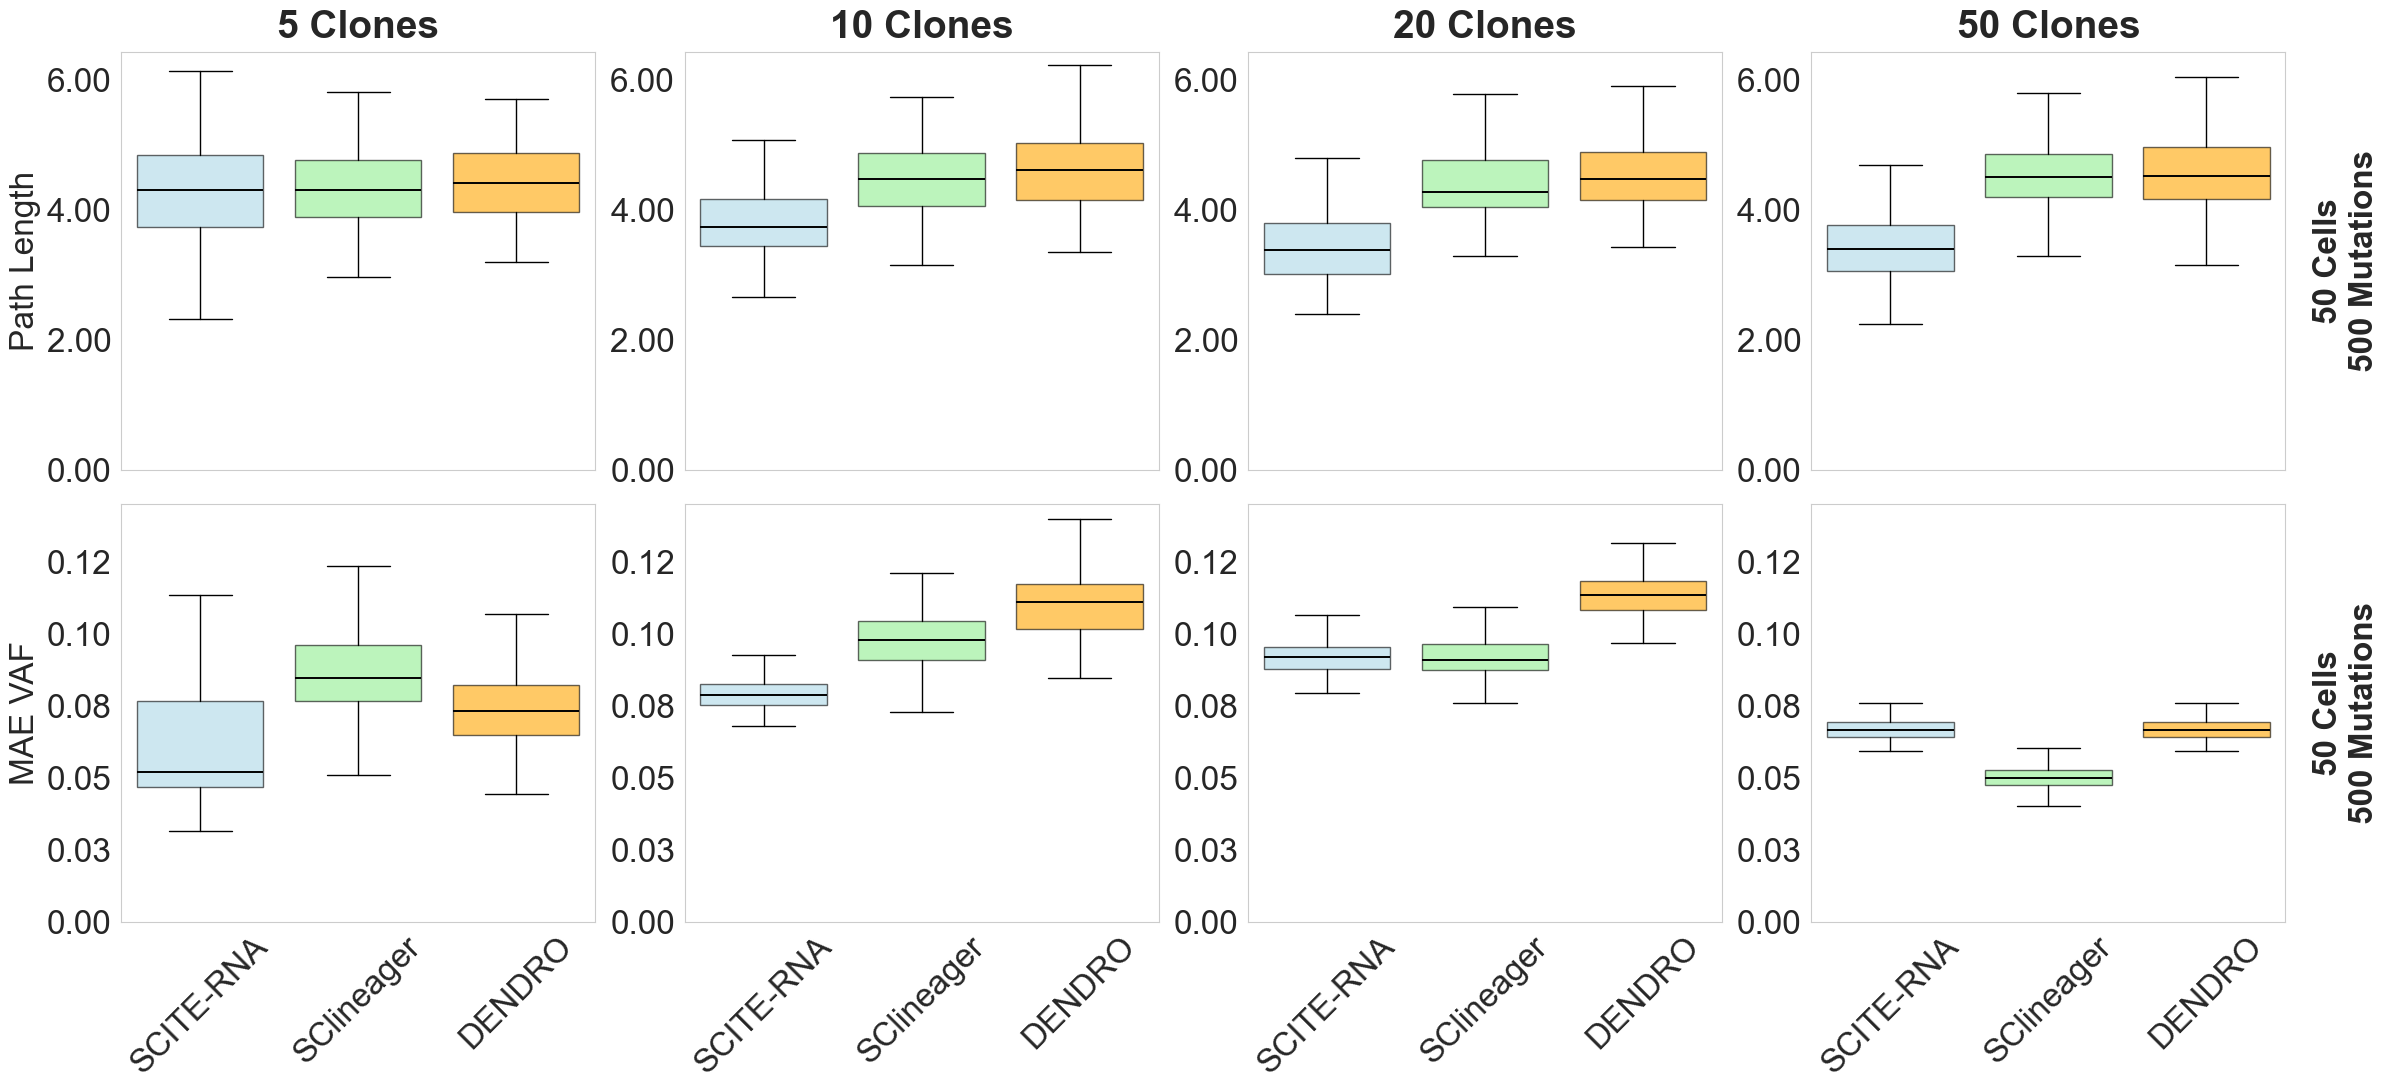

In [17]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO"]):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties

    # Configuration
    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 28
    label_size = 24
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Length", "MAE VAF"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/combined_PathLength_VAF.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, genotype_differences, [5, 10, 20, ""])

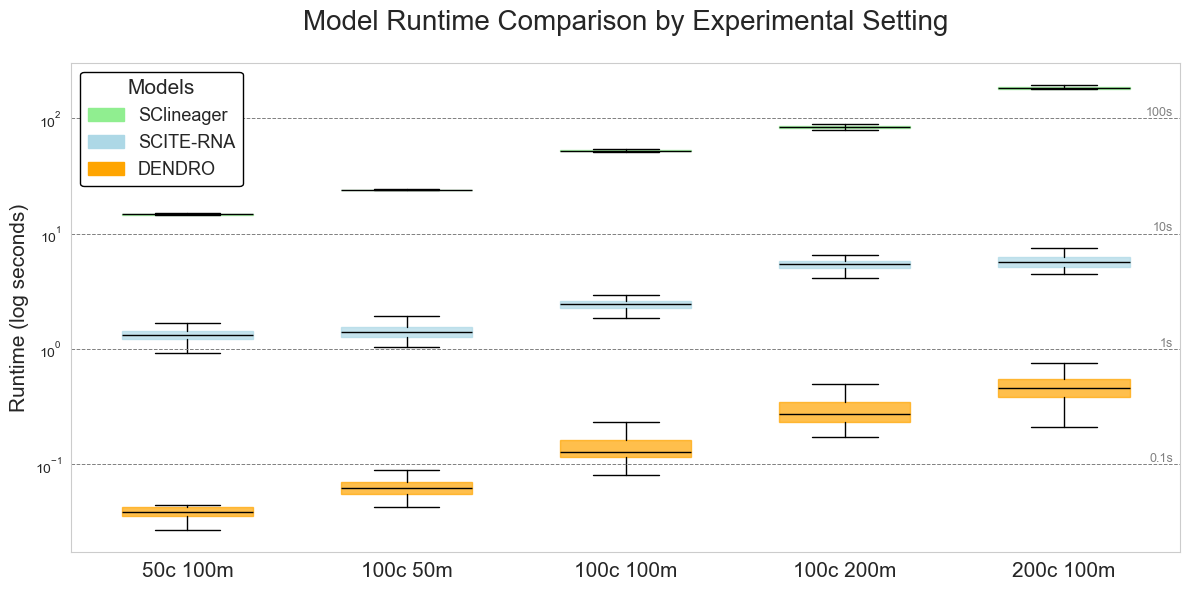

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

n_cells = [50, 100, 100, 100, 200]
n_mut = [100, 50, 100, 200, 100]
path = "../data/simulated_data/"
clone = ""
stratified = ""
models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

# Store runtimes per model per condition
runtime_data = {model: [] for model in models}
conditions = []

# Collect runtime data
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
    try:
        scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
        sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
        dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
    except Exception as e:
        print(f"Error loading data for {condition_label}: {e}")
        continue

    runtime_data["SCITE-RNA"].append(scite_rna)
    runtime_data["SClineager"].append(sclineager)
    runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

# Organize data for plotting
for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

# Color boxes
for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.7)

# Style medians
for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(1.0)

# Axis formatting
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=15)
ax.set_title("Model Runtime Comparison by Experimental Setting", fontsize=20, y=1.05)
ax.set_yscale("log")
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=9, color='gray', zorder=1)

# Add legend
legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
# plt.savefig("../data/results/figures/model_runtime_comparison.pdf")
plt.show()